Выполнил: Бешляга Григорий Константинович

Мультивариативный ряд: временные ряды метеорологических данных.<br>
Решаем задачу регресии. Предсказываем такие характеристики, как: атмосферное давление, температура воздуха, дефицит пара.
Замеры данных проводятся каждые 10 минут, период: 2009-2016 год.

In [2]:
!pip install pmdarima
!pip install tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tcn (from versions: none)
ERROR: No matching distribution found for tcn


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
from tqdm import tqdm
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

my_seed = 52
torch.manual_seed(my_seed)
torch.cuda.manual_seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

file_path = '/content/Weather Data (1).csv'
data = pd.read_csv(file_path)
data = data.drop(['Weather'], axis = 1)

## Блок предобработки временного ряда
### Свойства временных рядов

Просмотр основной информации о мультивариационном ряде

In [ ]:
data

Date/Time  Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  \
0        1/1/2012 0:00    -1.8              -3.9         86                4   
1        1/1/2012 1:00    -1.8              -3.7         87                4   
2        1/1/2012 2:00    -1.8              -3.4         89                7   
3        1/1/2012 3:00    -1.5              -3.2         88                6   
4        1/1/2012 4:00    -1.5              -3.3         88                7   
...                ...     ...               ...        ...              ...   
8779  12/31/2012 19:00     0.1              -2.7         81               30   
8780  12/31/2012 20:00     0.2              -2.4         83               24   
8781  12/31/2012 21:00    -0.5              -1.5         93               28   
8782  12/31/2012 22:00    -0.2              -1.8         89               28   
8783  12/31/2012 23:00     0.0              -2.1         86               30   

      Visibility_km  Press_kPa  
0               8.0     101.24  
1               8.0     101.24  
2               4.0     101.26  
3               4.0     101.27  
4               4.8     101.23  
...             ...        ...  
8779            9.7     100.13  
8780            9.7     100.03  
8781            4.8      99.95  
8782            9.7      99.91  
8783           11.3      99.89  

[8784 rows x 7 columns]

In [ ]:
data.describe()

Temp_C  Dew Point Temp_C    Rel Hum_%  Wind Speed_km/h  \
count  8784.000000       8784.000000  8784.000000      8784.000000   
mean      8.798144          2.555294    67.431694        14.945469   
std      11.687883         10.883072    16.918881         8.688696   
min     -23.300000        -28.500000    18.000000         0.000000   
25%       0.100000         -5.900000    56.000000         9.000000   
50%       9.300000          3.300000    68.000000        13.000000   
75%      18.800000         11.800000    81.000000        20.000000   
max      33.000000         24.400000   100.000000        83.000000   

       Visibility_km    Press_kPa  
count    8784.000000  8784.000000  
mean       27.664447   101.051623  
std        12.622688     0.844005  
min         0.200000    97.520000  
25%        24.100000   100.560000  
50%        25.000000   101.070000  
75%        25.000000   101.590000  
max        48.300000   103.650000

Графики временных рядов

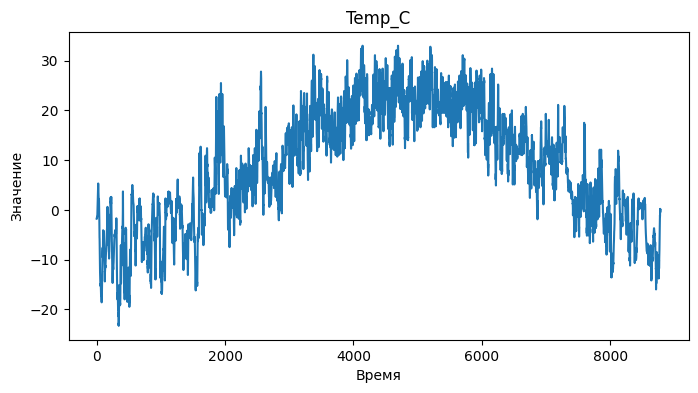

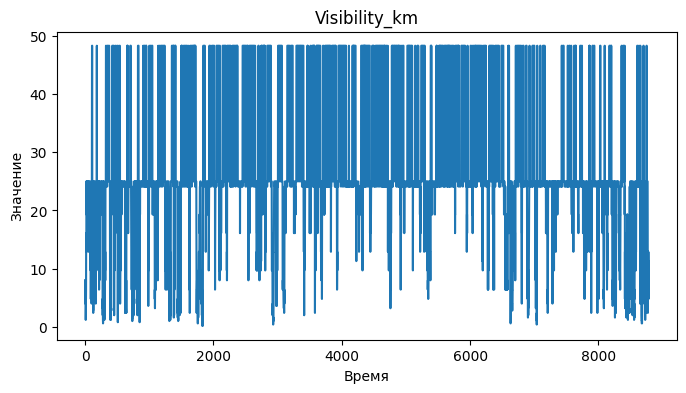

In [ ]:
columns = data.columns

for column in columns:
    if column != 'Date/Time':
        plt.figure(figsize=(8, 4))
        plt.plot(data[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()

Проверка на то, что все данные передаются через равный промежуток времени. Данные в датасете передаются через одну минуту.

In [ ]:
# time_diff = data['Date/Time'].diff()
# time_diff.unique()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

Просмотр пропущенных значений во временном ряде

In [ ]:
missing_values = data.isnull().sum()
missing_values

Date/Time           0
Temp_C              0
Dew Point Temp_C    0
Rel Hum_%           0
Wind Speed_km/h     0
Visibility_km       0
Press_kPa           0
dtype: int64

Посмотрим на составляющие временного ряда.

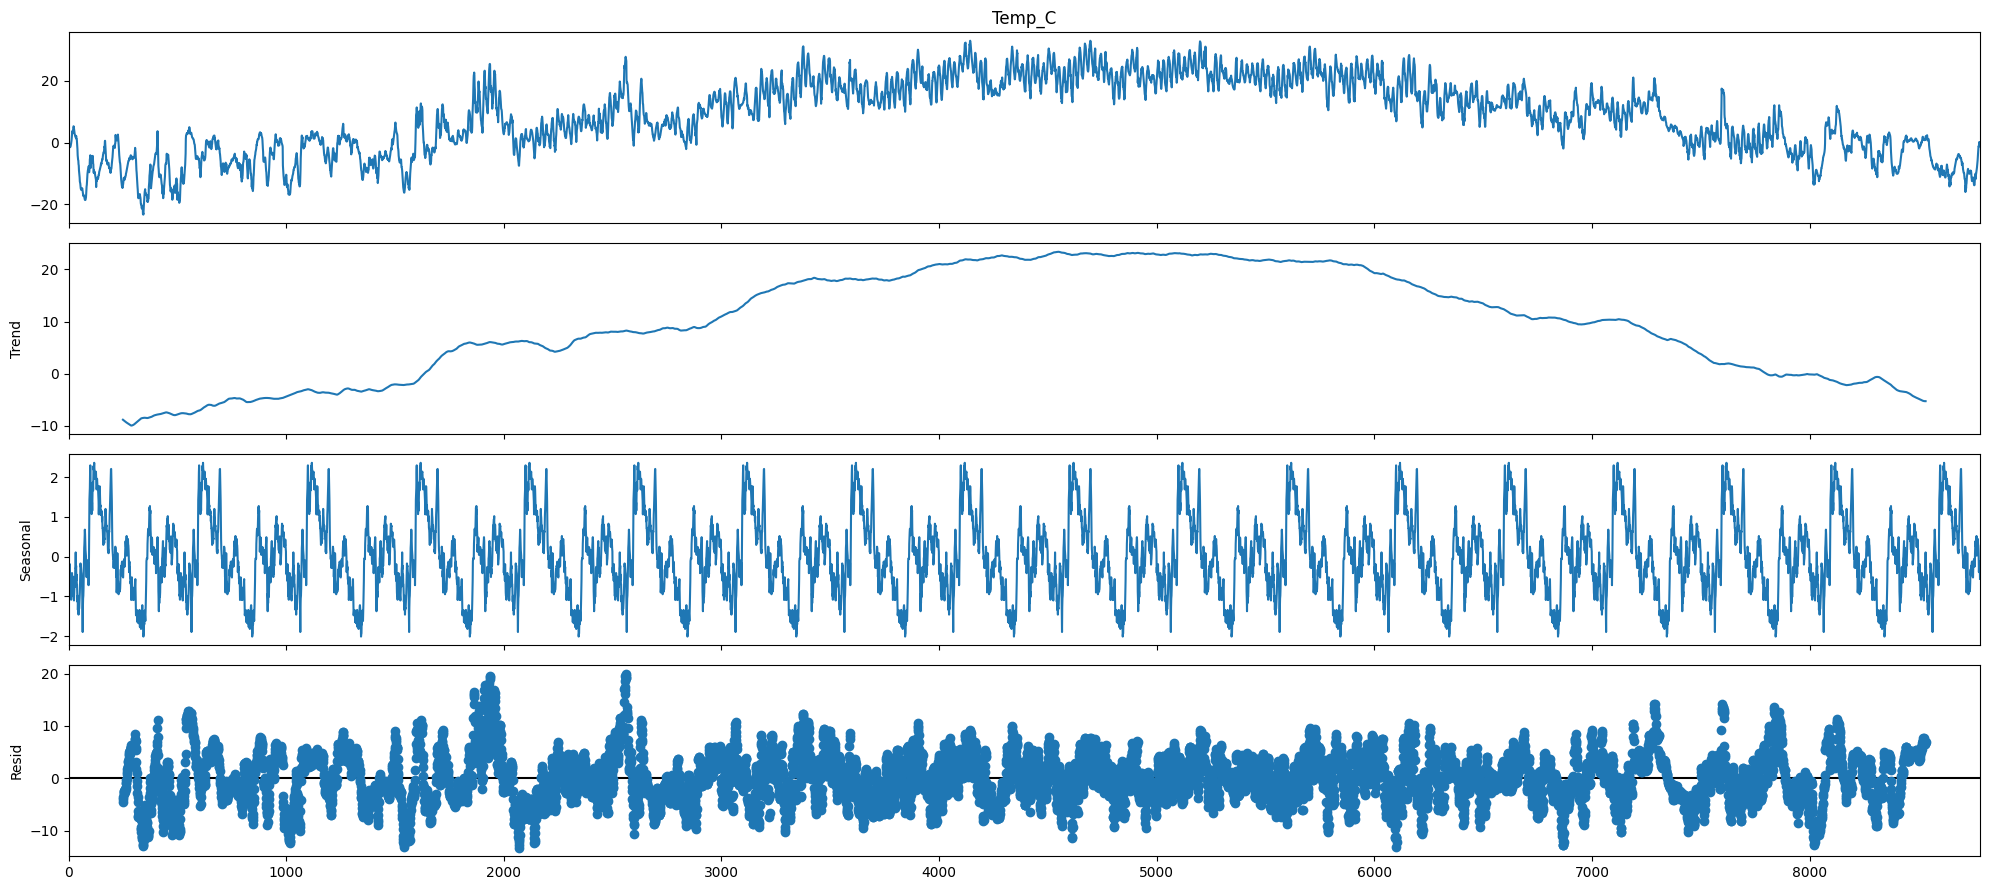

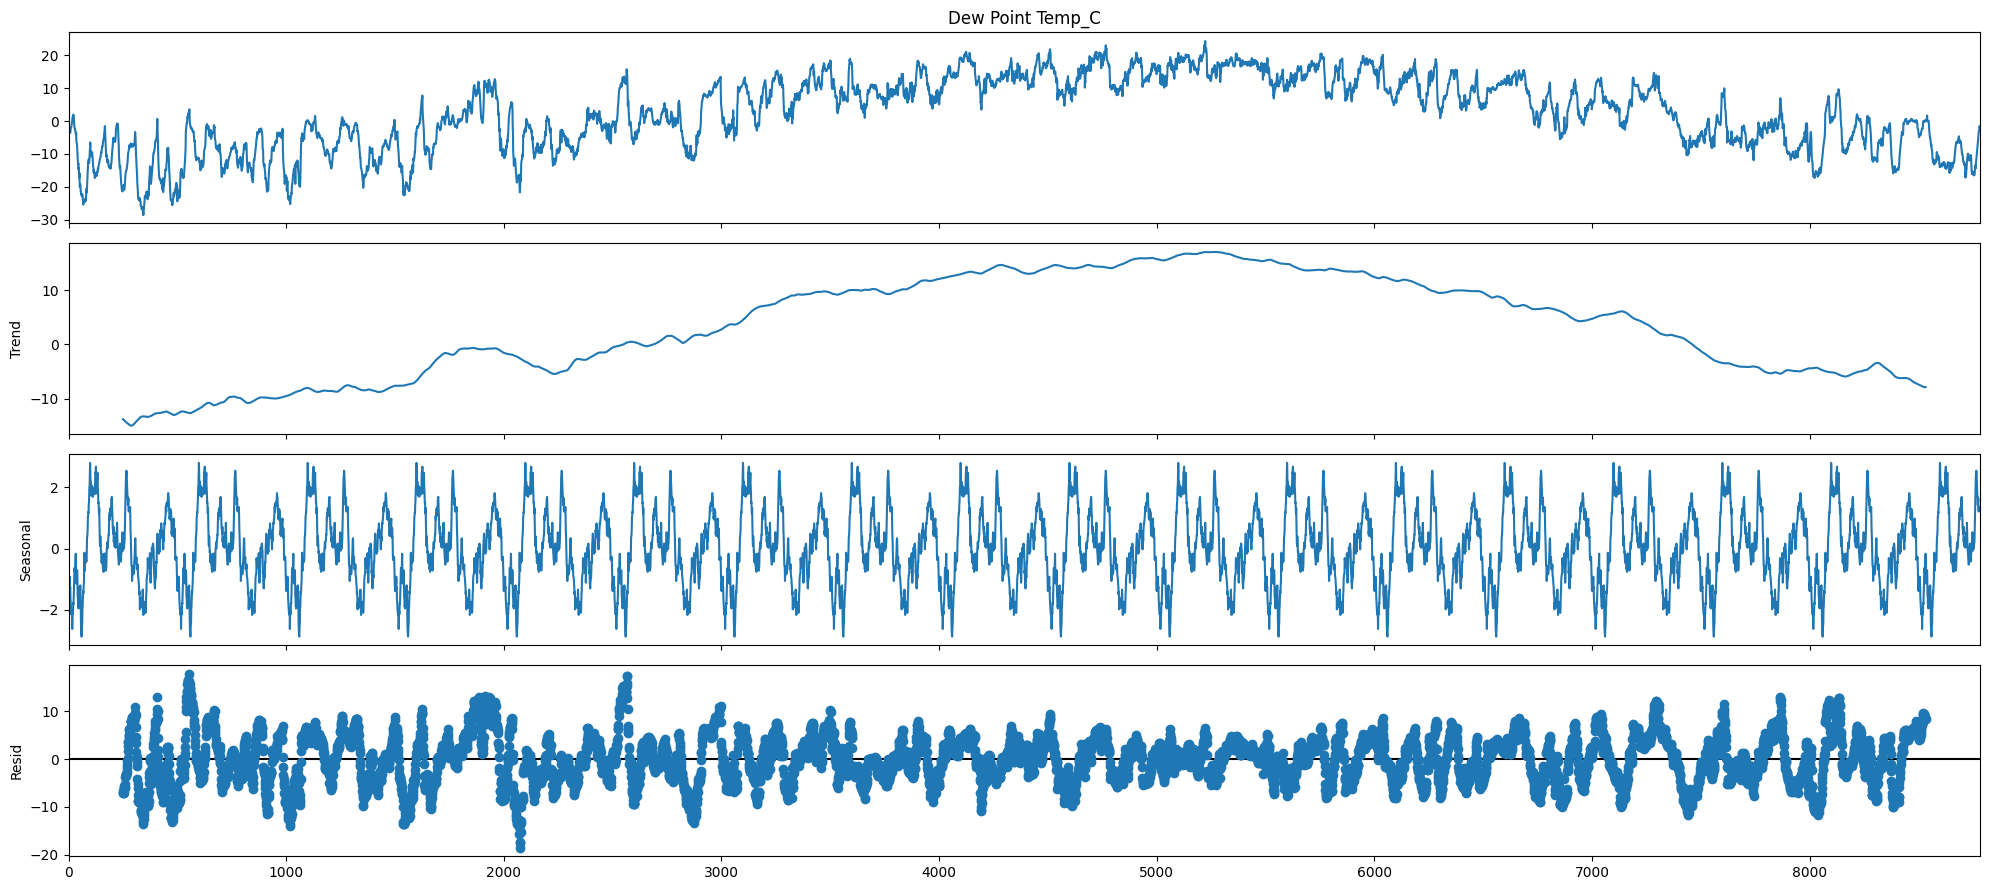

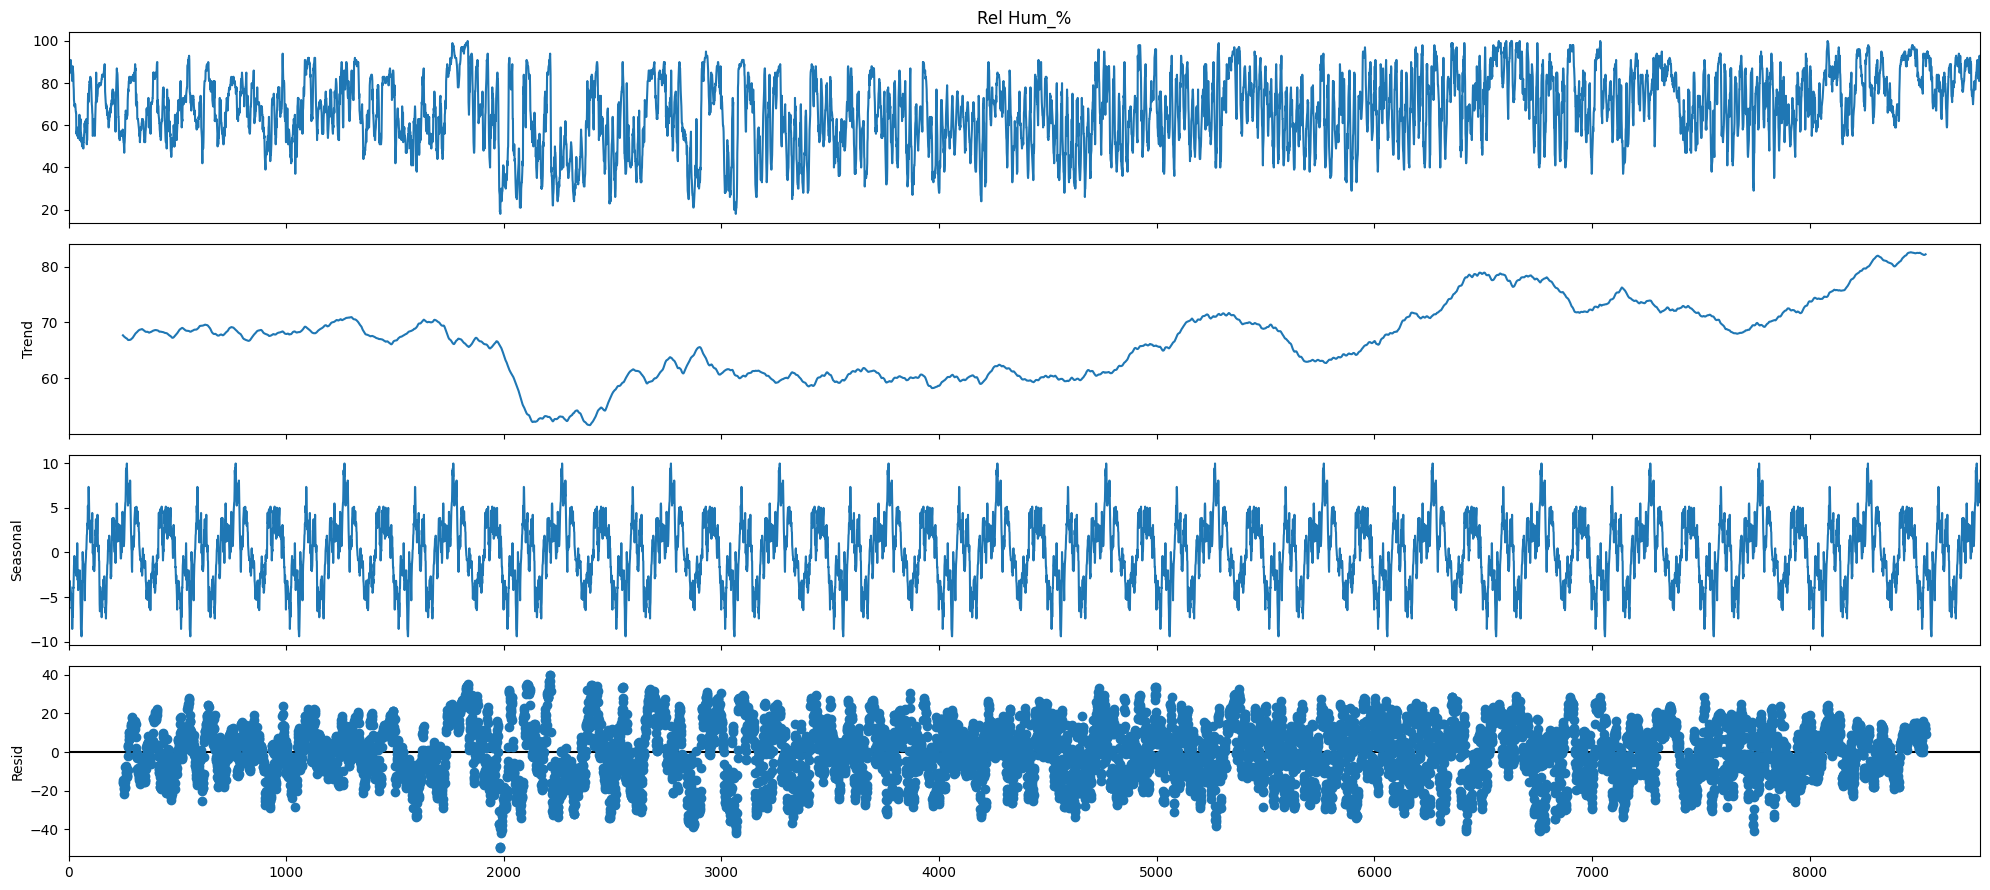

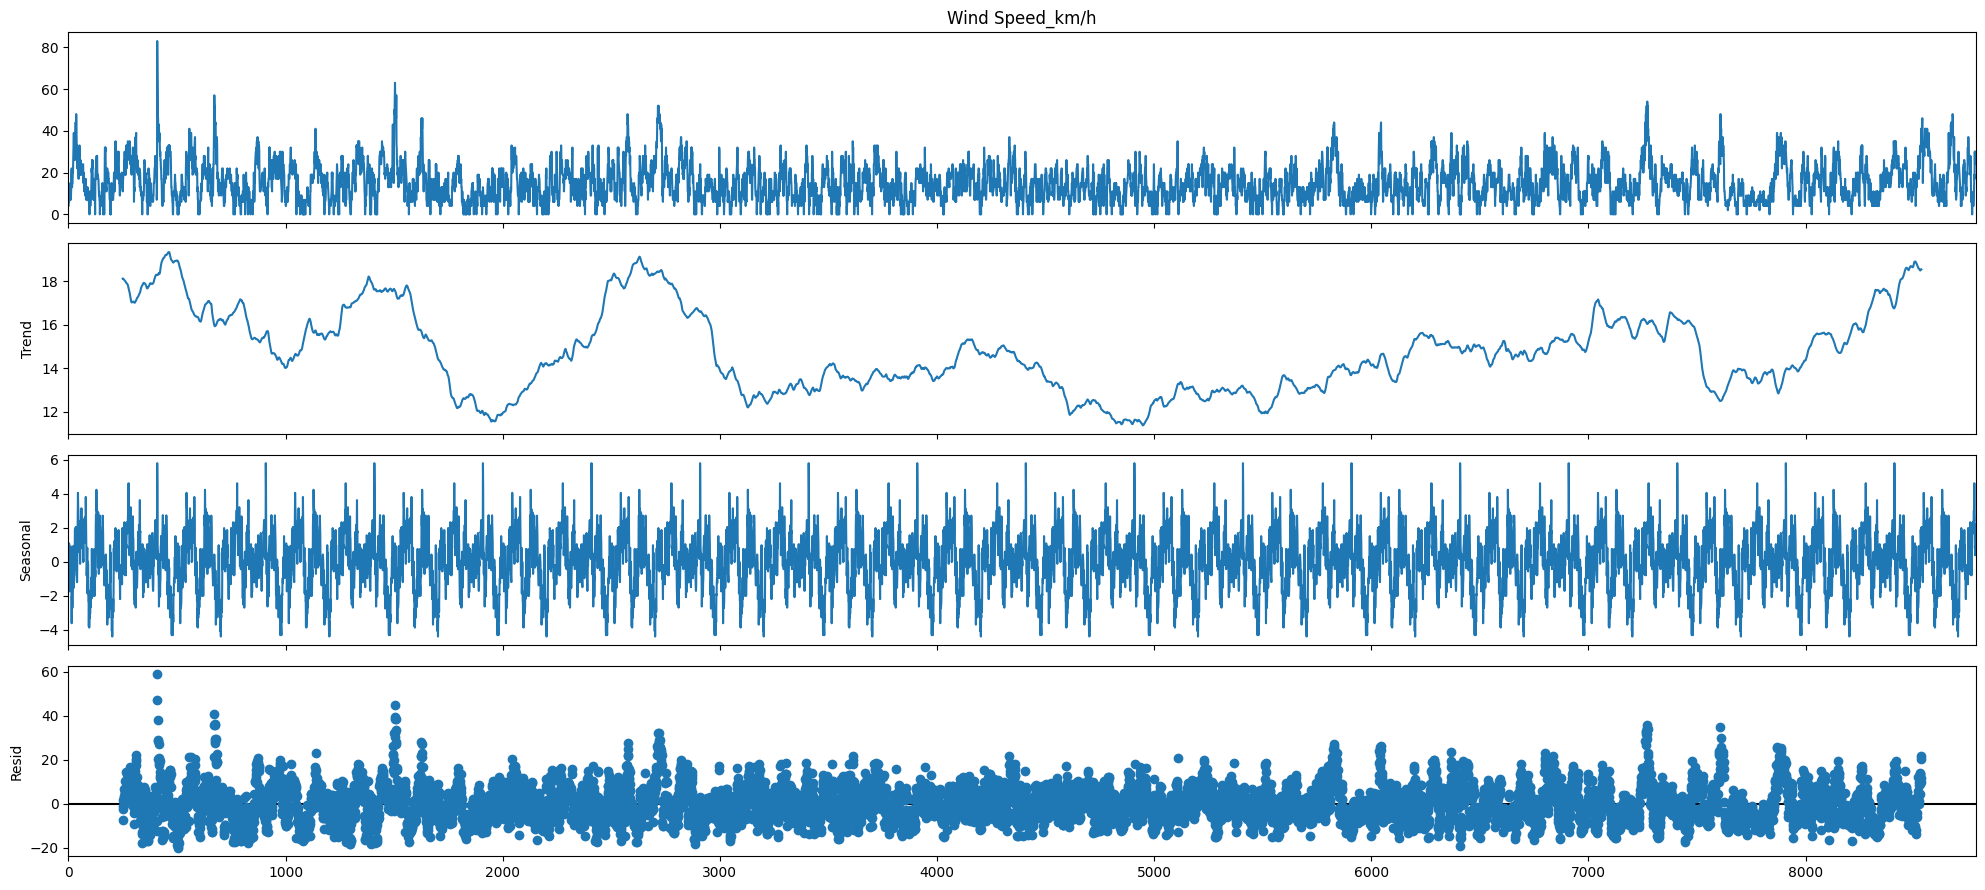

In [ ]:
for col in data.columns:
    if col != 'Date/Time':
        rcParams['figure.figsize'] = 20, 9
        decompose = seasonal_decompose(data[col], period=500)
        decompose.plot()
        plt.show()

Из графиков видно, что тренд отсутствуют, наблюдается сезонность.<br>

Проверка рядов на стационарность

In [ ]:
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [ ]:
for col in data.columns:
    if col != 'Date/Time':
        df_test(col, data[col])

Тест Дики-Фуллера ряда Temp_C:
Test Statistic                   -3.252861
p-value                           0.017122
#Lags Users                      37.000000
Number of Observations Used    8746.000000
Critical Value (1%)              -3.431098
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Dew Point Temp_C:
Test Statistic                   -4.760585
p-value                           0.000065
#Lags Users                      32.000000
Number of Observations Used    8751.000000
Critical Value (1%)              -3.431097
Critical Value (5%)              -2.861870
Critical Value (10%)             -2.566946
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Rel Hum_%:
Test Statistic                -1.155091e+01
p-value                        3.449423e-21
#Lags Users                    2.600000e+01
Number of Observations Used    8.757000e+03
Cr

Для прогнозирования в моделях VAR, VARMA важна стационарность.<br>
Для нейронок это уже необязательно.

### Коинтеграция

Коинтеграция временных рядов – причинно-следственная зависимость в уровнях двух и более временных рядов, которая выражается в совпадении или противоположной направленности тенденций данных рядов и случайной колеблемости.

Если временные ряды коинтегрированы, это обычно означает, что можно строить модели, учитывающие их долгосрочные взаимосвязи для лучших предсказаний (VAR, VARMA и т.д.).

In [8]:
del data['Date/Time']

pairs = combinations(data.columns, 2)

for pair in pairs:
    pair_data = data[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между Temp_C и Dew Point Temp_C
Есть коинтеграция между Temp_C и Rel Hum_%
Есть коинтеграция между Temp_C и Wind Speed_km/h
Есть коинтеграция между Temp_C и Visibility_km
Отсутствует коинтеграция между Temp_C и Press_kPa
Есть коинтеграция между Dew Point Temp_C и Rel Hum_%
Есть коинтеграция между Dew Point Temp_C и Wind Speed_km/h
Есть коинтеграция между Dew Point Temp_C и Visibility_km
Есть коинтеграция между Dew Point Temp_C и Press_kPa
Есть коинтеграция между Rel Hum_% и Wind Speed_km/h
Есть коинтеграция между Rel Hum_% и Visibility_km
Есть коинтеграция между Rel Hum_% и Press_kPa
Есть коинтеграция между Wind Speed_km/h и Visibility_km
Есть коинтеграция между Wind Speed_km/h и Press_kPa
Есть коинтеграция между Visibility_km и Press_kPa


Причинность рядов по Грейнджеру

In [ ]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(data, variables = data.columns)
warnings.filterwarnings("default")
j_test

100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Temp_C_x  Dew Point Temp_C_x  Rel Hum_%_x  \
Temp_C_y                 1.0              0.0000          0.0   
Dew Point Temp_C_y       0.0              1.0000          0.0   
Rel Hum_%_y              0.0              0.0000          1.0   
Wind Speed_km/h_y        0.0              0.0000          0.0   
Visibility_km_y          0.0              0.0001          0.0   
Press_kPa_y              0.0              0.0000          0.0   

                    Wind Speed_km/h_x  Visibility_km_x  Press_kPa_x  
Temp_C_y                       0.0000              0.0          0.0  
Dew Point Temp_C_y             0.0000              0.0          0.0  
Rel Hum_%_y                    0.0000              0.0          0.0  
Wind Speed_km/h_y              1.0000              0.0          0.0  
Visibility_km_y                0.0000              1.0          0.0  
Press_kPa_y                    0.0041              0.0          1.0

Если результат теста Грейнджера показывает строгое значение p-уровня значимости равное нулю или близкое к нулю (< 0.05) для пары временных рядов, это обычно интерпретируется как сильное статистическое доказательство в пользу наличия причинной связи между этими рядами. Ну и как итог - VAR модели подходят идеально.

## Прогнозирование временного ряда

#### VAR

VAR (Vector AutoRegression) - это тип статистической модели временных рядов, используемой для прогнозирования изменений в нескольких взаимосвязанных переменных с течением времени. Это многомерное расширение модели авторегрессии (AR).

VAR моделирует каждую переменную как линейную комбинацию ее предыдущих значений и предыдущих значений других переменных. Таким образом, все переменные в системе рассматриваются как эндогенные, и модель позволяет нам улучшить прогнозы путем учета взаимосвязей между переменными.

Для начала - подберем наилучший порядок, исходя из информационных критериев:<br>

AIC (Akaike Information Criterion)<br>
BIC (Bayesian Information Criterion)<br>
FPE (Final Prediction Error)<br>
HQC (Hannan-Quinn Criterion).<br>

Меньшие значения критериев указывают на лучшую модель, и их можно использовать для выбора оптимального порядка модели VAR.

In [67]:
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):len(data)]

model = VAR(train)

orders = [2,6,12,20,24,30,40,48,50,96,168,252,336]
AIC_min = 1
BIC_min = 1
FPE_min = 1
HQC_min = 1

results = [[],[],[],[]]
for i in orders:
    result = model.fit(i)
    results[0].append(result.aic)
    results[1].append(result.bic)
    results[2].append(result.fpe)
    results[3].append(result.hqic)

best_pos = [np.argmin(results[0]),np.argmin(results[1]),np.argmin(results[2]),np.argmin(results[3])]

for i,j in enumerate(zip(*results)):
    print('Lag Order =', orders[i])
    print('AIC : ', j[0], "*" if i == best_pos[0] else "")
    print('BIC : ', j[1], "*" if i == best_pos[1] else "")
    print('FPE : ', j[2], "*" if i == best_pos[2] else "")
    print('HQIC: ', j[3], "*" if i == best_pos[3] else "", '\n')

Lag Order = 2
AIC :  0.13288469435569364 
BIC :  0.20902191550128107 
FPE :  1.142118327002882 
HQIC:  0.15911565867595126  

Lag Order = 6
AIC :  -0.11316392849063941 
BIC :  0.10363976443313633 *
FPE :  0.8930047820685985 
HQIC:  -0.038468101410068595 * 

Lag Order = 12
AIC :  -0.17579200179118168 
BIC :  0.2522683010927833 
FPE :  0.8387962137139218 
HQIC:  -0.02830515923585808  

Lag Order = 20
AIC :  -0.22756799314998413 
BIC :  0.4826484672463349 
FPE :  0.7964846738280367 
HQIC:  0.01714890614656256  

Lag Order = 24
AIC :  -0.2624129016045762 
BIC :  0.5890881264777172 
FPE :  0.7692206760708568 
HQIC:  0.03099436620355356  

Lag Order = 30
AIC :  -0.29299303234911583 *
BIC :  0.7706935656949092 
FPE :  0.7460790165703495 *
HQIC:  0.07354419140866619  

Lag Order = 40
AIC :  -0.2619743573286902 
BIC :  1.156046579220164 
FPE :  0.7696571748023584 
HQIC:  0.226698546325375  

Lag Order = 48
AIC :  -0.2418065799462666 
BIC :  1.4603063350237493 
FPE :  0.7854313269618064 
HQIC:  

Обучаем модель с наилучшим порядком (12)

In [68]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Jan, 2024
Time:                     20:52:44
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   0.252268
Nobs:                     7015.00    HQIC:                -0.0283052
Log likelihood:          -58668.5    FPE:                   0.838796
AIC:                    -0.175792    Det(Omega_mle):        0.788280
--------------------------------------------------------------------
Results for equation Temp_C
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -5.566902         1.917730           -2.903           0.004
L1.Temp_C                    1.325409         0.036627           36.187           0.000
L1.Dew Point Temp_C         -0.

Теперь подготовим тестовые данные для предсказания, и сделаем их

In [69]:
def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)].to_numpy())
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_test, Y_test

def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)].to_numpy())
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_train, Y_train

In [70]:
X_test, Y_test = create_test_dataset(test, 12)
X_train, Y_train = create_train_dataset(train, 12)

In [71]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [72]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

Посчитаем метрики и отрисуем графики.

In [73]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)

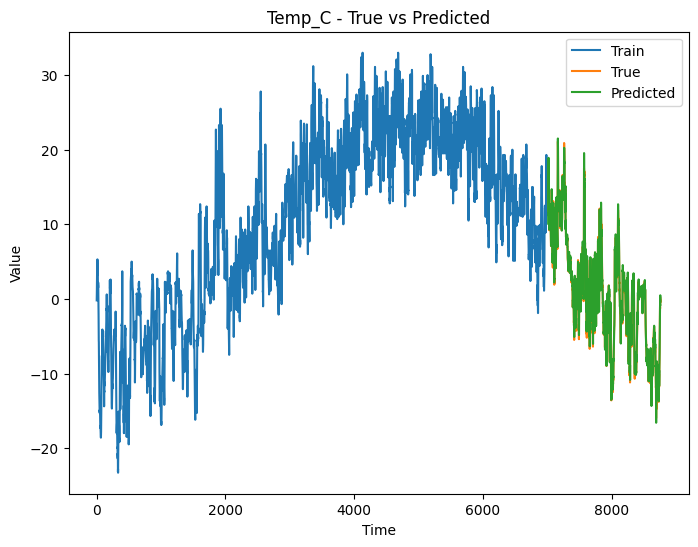

Метрики Temp_C
MSE: 0.6530481458520064
RMSE: 0.8081139436069683
MAE: 0.5665855740085471
SMAPE: 0.061
R2: 0.9872153977388797 



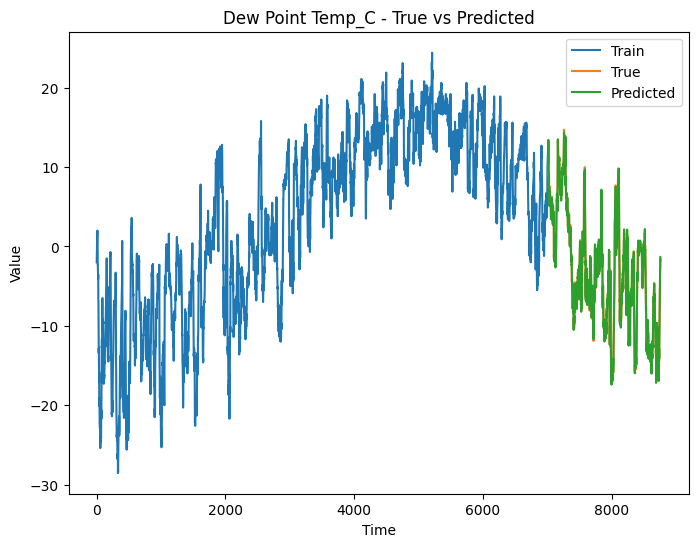

Метрики Dew Point Temp_C
MSE: 0.5397190910636781
RMSE: 0.7346557636496689
MAE: 0.5129505700743794
SMAPE: 0.057
R2: 0.9891252544607747 



Метрики Rel Hum_%
MSE: 16.337210381546466
RMSE: 4.0419315161870895
MAE: 2.9221013534687628
SMAPE: 0.01
R2: 0.9087049474791276 



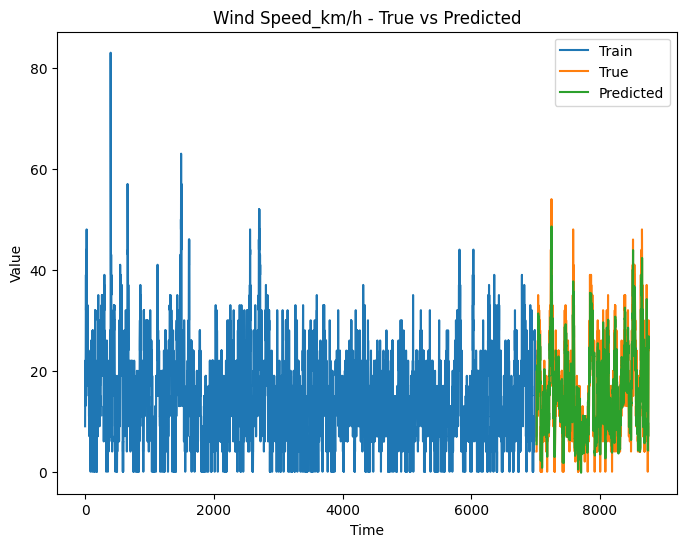

Метрики Wind Speed_km/h
MSE: 17.64116045366557
RMSE: 4.200138146973926
MAE: 3.1574836410704377
SMAPE: 0.065
R2: 0.8005766483242371 



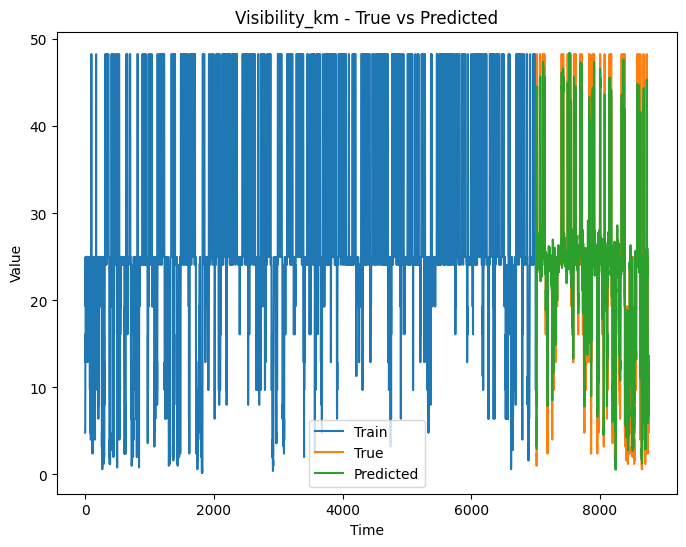

Метрики Visibility_km
MSE: 27.479355461764214
RMSE: 5.242075491803243
MAE: 2.921864394786079
SMAPE: 0.043
R2: 0.7459087329021237 



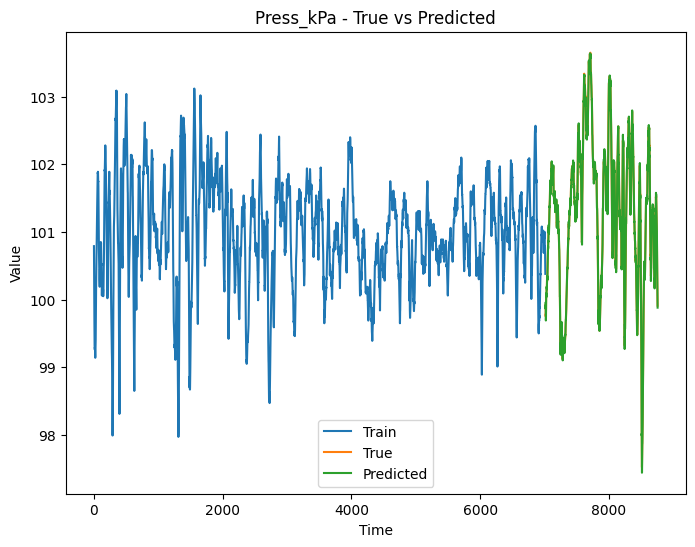

Метрики Press_kPa
MSE: 0.001692237524792354
RMSE: 0.041136814713737306
MAE: 0.030737229939761926
SMAPE: 0.0
R2: 0.9985578780345818 



In [74]:
plot_and_metrics(data.columns, Y_test, Y_pred, Y_train)

По метрикам:<br>

Адекватное MSE, RMSE, MAE - ниже единицы, что есть хорошо, близко к нулю.<br>
SMAPE тоже показывает себя неплохо (где-то в итоге около нуля, что идеально).<br>
R2 ~= 0.99, почти отлично, очень близко к единице.<br>

#### VARMA

VARMA (Vector AutoRegressive Moving-Average) - это стохастическая модель, используемая в области временных рядов для моделирования взаимосвязей между несколькими временными рядами одновременно. В этой модели предполагается, что каждый из временных рядов влияет на другие.

VARMA - это обобщение модели ARMA (AutoRegressive Moving Average). В модели ARMA каждый временной ряд моделируется на основе его собственных предыдущих значений (авторегрессионный элемент) и ошибок прогнозирования (скользящая средняя).

Однако в модели VARMA каждый временной ряд моделируется не только на основе его собственных предыдущих значений, но и на основе предыдущих значений других временных рядов.

In [27]:
X = data
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):len(data)]

Подберём оптимальные параметры для обучения при помощи AutoArima.<br>

In [9]:
pq = []
for name, column in data.items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Temp_C
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23574.958, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25488.137, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23974.311, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24474.098, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25486.138, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23510.313, Time=3.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23543.734, Time=0.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23481.742, Time=4.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23487.177, Time=0.98 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=22958.011, Time=8.35 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=23471.015, Time=2.33 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=22899.191, Time=10.87 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=23422.911, Time=2.24 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=228

In [10]:
pq

[(7, 1, 1), (1, 1, 2), (3, 1, 0), (1, 1, 1), (0, 1, 7), (1, 1, 3)]

Подберем опытным путём наилучший порядок

In [28]:
df_results_moni = pd.DataFrame(columns=['p', 'q','Temp_C','Dew Point Temp_C','Rel Hum_%','Wind Speed_km/h','Visibility_km','Press_kPa'])
# df_results_moni['p'] = pd.to_numeric(df_results_moni['p'], errors='coerce')
# df_results_moni['q'] = pd.to_numeric(df_results_moni['q'], errors='coerce')
# df_results_moni['Temp_C'] = pd.to_numeric(df_results_moni['Temp_C'], errors='coerce')
# df_results_moni['Dew Point Temp_C'] = pd.to_numeric(df_results_moni['Dew Point Temp_C'], errors='coerce')
# df_results_moni['Rel Hum_%'] = pd.to_numeric(df_results_moni['Rel Hum_%'], errors='coerce')
# df_results_moni['Wind Speed_km/h'] = pd.to_numeric(df_results_moni['Wind Speed_km/h'], errors='coerce')
# df_results_moni['Visibility_km'] = pd.to_numeric(df_results_moni['Visibility_km'], errors='coerce')
# df_results_moni['Press_kPa'] = pd.to_numeric(df_results_moni['Press_kPa'], errors='coerce')
df_results_moni = df_results_moni.apply(pd.to_numeric, errors='coerce')


for i in pq[1:len(pq)]:
    if i[0]== 0 and i[2]==0:
        pass
    else:
        model = VARMAX(train, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(test))
        # p_mbar_srmse = np.sqrt(metrics.mean_squared_error(test['p (mbar)'], result['p (mbar)']))
        # t_degc_rmse = np.sqrt(metrics.mean_squared_error(test['T (degC)'], result['T (degC)']))
        # vpdef_mbar_rmse = np.sqrt(metrics.mean_squared_error(test['VPdef (mbar)'], result['VPdef (mbar)']))
        temp_c_rmse = np.sqrt(metrics.mean_squared_error(test['Temp_C'], result['Temp_C']))
        dew_point_temp_c_rmse = np.sqrt(metrics.mean_squared_error(test['Dew Point Temp_C'], result['Dew Point Temp_C']))
        rel_hum_proc_rmse = np.sqrt(metrics.mean_squared_error(test['Rel Hum_%'], result['Rel Hum_%']))
        wind_speed_rmse = np.sqrt(metrics.mean_squared_error(test['Wind Speed_km/h'], result['Wind Speed_km/h']))
        visibility_km_rmse = np.sqrt(metrics.mean_squared_error(test['Visibility_km'], result['Visibility_km']))
        press_kpa_rmse = np.sqrt(metrics.mean_squared_error(test['Press_kPa'], result['Press_kPa']))
        new_row = {'p': i[0], 'q': i[2], 'RMSE Temp_C': temp_c_rmse,'RMSE Dew Point Temp_C': dew_point_temp_c_rmse,'RMSE Rel Hum_%': rel_hum_proc_rmse,
                   'RMSE Wind Speed_km/h': wind_speed_rmse, 'RMSE Visibility_km': visibility_km_rmse, 'RMSE Press_kPa': press_kpa_rmse}
        df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


KeyboardInterrupt: 

In [29]:
df_results_moni.sort_values(by = ['Temp_C','Dew Point Temp_C','Rel Hum_%','Wind Speed_km/h','Visibility_km','Press_kPa'] )

Empty DataFrame
Columns: [p, q, Temp_C, Dew Point Temp_C, Rel Hum_%, Wind Speed_km/h, Visibility_km, Press_kPa]
Index: []

Наилучшие p, q - 3,1

In [26]:
model = VARMAX(train, order=(3,1)).fit(disp=False)
result = model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

Посмотрим на полученный результат

In [64]:
result

NameError: name 'result' is not defined

Считаем метрики и отрисовываем предсказания.

In [65]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'SMAPE: {smape_score(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [66]:
for i in ['Temp_C','Dew Point Temp_C','Rel Hum_%','Wind Speed_km/h','Visibility_km','Press_kPa']:
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(train[str(i)], label='Train '+str(i))
    plt.plot(range(25000, 30000), test[str(i)], label='Test '+str(i))
    plt.plot(range(25000, 30000), result[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , result[str(i)])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Нейросети

#### LSTM

LSTM (Long Short-Term Memory) - это тип рекуррентной нейронной сети (RNN), разработанный для работы с последовательными данными, такими как временные ряды, тексты, аудио и другие последовательные данные.

Основная особенность LSTM заключается в способности учитывать зависимости и долгосрочные зависимости в данных, что часто бывает сложно для обычных RNN. Они обладают способностью запоминать информацию на протяжении длительных временных интервалов и избегать проблемы затухания/взрыва градиентов, которая часто встречается у обычных RNN.

Определим саму модель нейросети.

In [30]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

Определим функцию разделения датасета

In [31]:
def data_split(ts, param="5", train_percentage=0.7):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

И создания для подачи на вход LSTM.

In [32]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

Создади функцию для обучения модели и предсказаний.

In [33]:
def train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_l1, n_epochs, patience=10):
    y_pred_train = None
    y_pred_test = None
    min_test_rmse = np.inf
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_l1(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_l1(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_l1(y_pred, y_test))

            if test_rmse < min_test_rmse:
                min_test_rmse = test_rmse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')

            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch} epochs')
                break

    return y_pred_train, y_pred_test, model

Подготовим данные и запустим на обучение.

В качестве оптимизатора используем Adam с параметрами модели, в качестве функции ошибки будем использовать MSE.

In [34]:
data_LSTM = data.copy()

train, test, total = data_split(data_LSTM)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 100

y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_fn, EPOCHS)

<ipython-input-32-d70e7fdd0ff0>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 60.5116, test RMSE 60.7650
Epoch 1: train RMSE 33.2285, test RMSE 33.4864
Epoch 2: train RMSE 14.0243, test RMSE 14.2923
Epoch 3: train RMSE 2.8962, test RMSE 3.2132
Epoch 4: train RMSE 1.9772, test RMSE 1.8811
Epoch 5: train RMSE 2.9570, test RMSE 2.8009
Epoch 6: train RMSE 3.0460, test RMSE 2.8865
Epoch 7: train RMSE 2.9310, test RMSE 2.7738
Epoch 8: train RMSE 2.7589, test RMSE 2.6071
Epoch 9: train RMSE 2.6867, test RMSE 2.5361
Epoch 10: train RMSE 2.5607, test RMSE 2.4148
Epoch 11: train RMSE 2.4517, test RMSE 2.3102
Epoch 12: train RMSE 1.0517, test RMSE 1.0895
Epoch 13: train RMSE 1.1480, test RMSE 1.1421
Epoch 14: train RMSE 1.0627, test RMSE 1.0827
Epoch 15: train RMSE 0.9549, test RMSE 1.0158
Epoch 16: train RMSE 0.8655, test RMSE 0.9751
Epoch 17: train RMSE 0.8067, test RMSE 0.9656
Epoch 18: train RMSE 0.8178, test RMSE 0.9640
Epoch 19: train RMSE 0.8082, test RMSE 0.9632
Epoch 20: train RMSE 0.7996, test RMSE 0.9625
Epoch 21: train RMSE 0.7843, test RMSE

Считаем метрики и для наглядности построим графики истинных меток и предсказаний.

LSTM metrics: 
SMAPE: 0.0
RMSE: 0.14323734057828963
MAE: 0.12455969
MSE: 0.020516936
R2: 0.9752180621765612


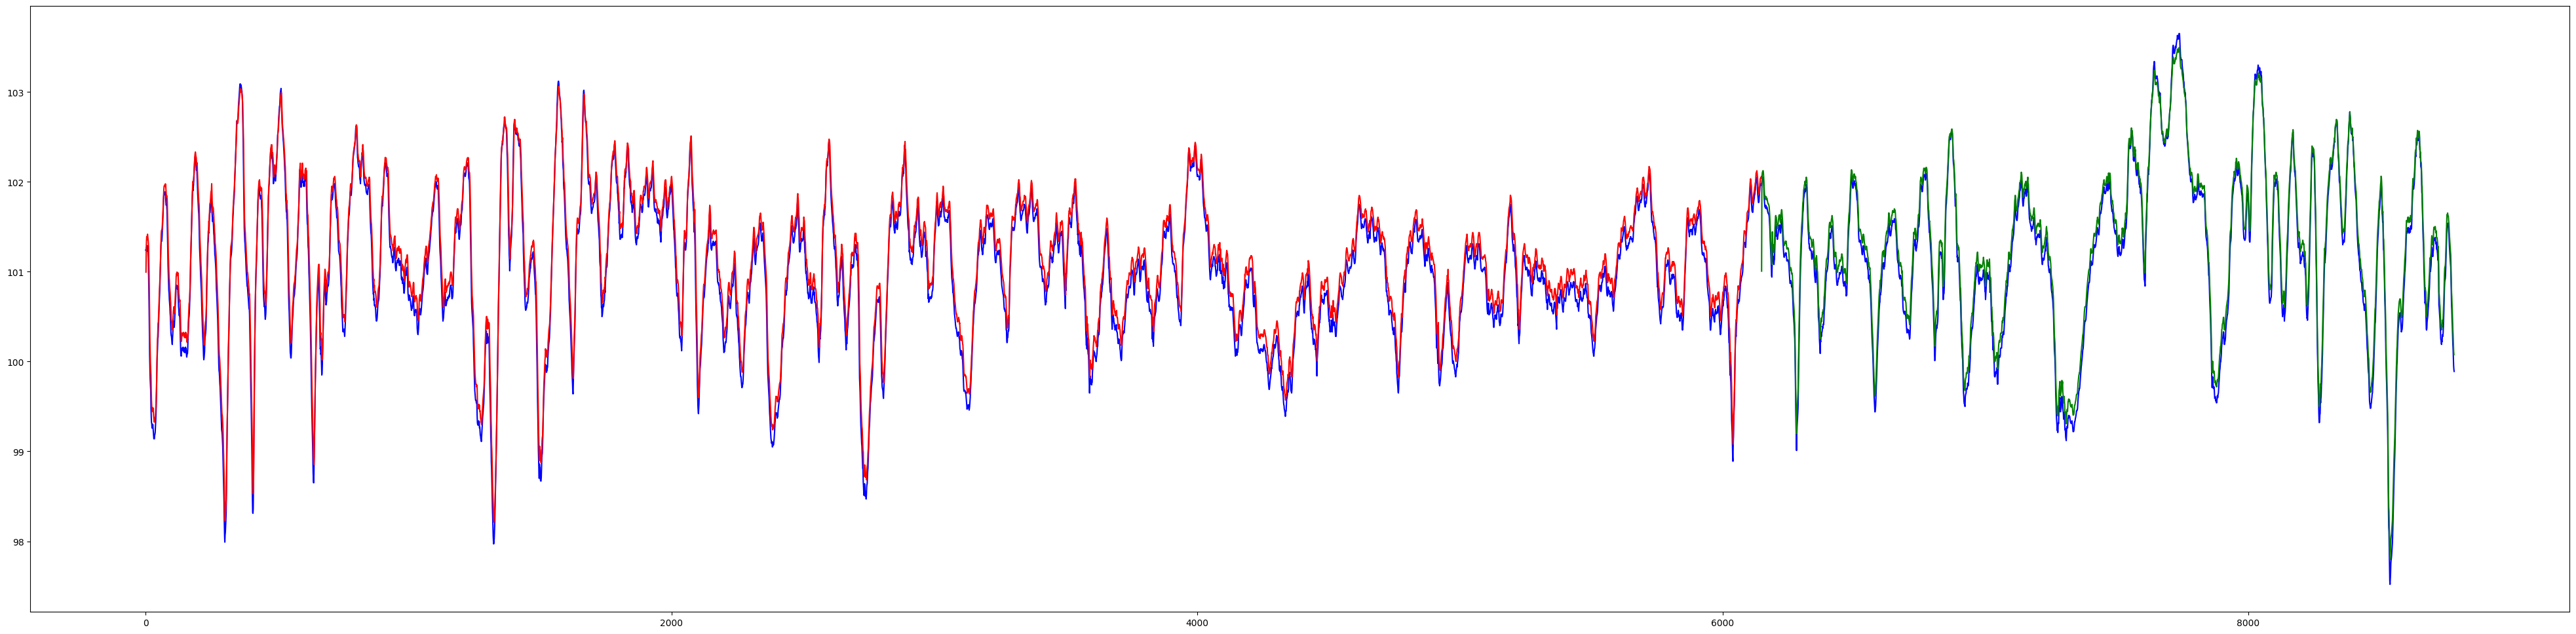

In [35]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]

    print("SMAPE:", smape_score(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MSE:", mean_squared_error(true, pred))
    print("R2:", r2_score(true, pred))

def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [50, 12]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

def validate_on_auto_measurement(model):
    valid_train, valid_test, valid_total = data_split(data)
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred

    print("LSTM metrics: ")
    try:
        validate(y_pred_test, y_test)
    except:
        validate(y_pred_test.detach(), y_test.detach())
    plot_train_n_pred(X_train, X_test, valid_total, model)

validate_on_auto_measurement(model)

По метрикам показало себе чуть лучше, чем классические модели.

MAE, MSE, RMSE в целом очень малы (< 1), что является почти отличным результатом.
SMAPE показал себя наилучшим образом, меньше 1 и даже близко к нулю, что очень приятно (но не идеально).

R2 ~= 0.98, что очень близко к единице, что очевидно является хорошим показателем.

#### GRU

GRU (Gated Recurrent Units) - это один из типов рекуррентных нейронных сетей, предложенный в 2014 году. Он был создан как более простая альтернатива LSTM (Long Short-Term Memory), другому типу рекуррентных сетей.

Главной отличительной особенностью GRU является меньшее число элементов управления или "ворот". У LSTM есть три ворота: входное, забывающее и выходное, а у GRU - всего два: обновляющее и сбрасывающее.

Обновляющее ворото в модели GRU определяет, какую часть предыдущего состояния следует сохранить, а сбрасывающее ворото контролирует, как много прошлого состояния использовать для вычисления текущего состояния.

По сути, GRU пытается решить проблему памяти в обычных рекуррентных сетях, взяв наиболее эффективные элементы LSTM, но упростив их. И, хотя GRU модели обычно требуют меньше объема вычислений по сравнению с LSTM, их эффективность сильно зависит от конкретной задачи.

Определим саму модель.

In [36]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=90, num_layers=1, batch_first=True)
        self.linear = nn.Linear(90, 1)
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

Определим функцию разделения датасета.

In [38]:
def data_split(ts, param="5", train_percentage=0.7):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

Определим функцию для создания данных на подаче вход нейросети.

In [39]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

Определим функцию обучения модели, включая тестирование на валидационной выборке.

In [40]:
def train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_l1, n_epochs, patience):
    y_pred_train = None
    y_pred_test = None
    min_test_rmse = np.inf
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_l1(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_l1(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_l1(y_pred, y_test))

            if test_rmse < min_test_rmse:
                min_test_rmse = test_rmse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')

            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch} epochs')
                break

    return y_pred_train, y_pred_test, model

Подготовим данные.<br>

Оптимизатор - Adamax, функция ошибки - MSE. Внутри обучения - RMSE.

In [41]:
data_GRU = data.copy()

train, test, total = data_split(data_GRU)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

model = GRUModel()
optimizer = optim.Adamax(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 100

train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_fn, EPOCHS, patience=10)

Epoch 0: train RMSE 11.6264, test RMSE 11.8871
Epoch 1: train RMSE 0.7767, test RMSE 1.0146
Epoch 2: train RMSE 0.7742, test RMSE 0.9943
Epoch 3: train RMSE 0.7742, test RMSE 0.9954
Epoch 4: train RMSE 0.7742, test RMSE 1.0000
Epoch 5: train RMSE 0.7743, test RMSE 0.9931
Epoch 6: train RMSE 0.7842, test RMSE 1.0353
Epoch 7: train RMSE 0.7747, test RMSE 0.9840
Epoch 8: train RMSE 0.7708, test RMSE 0.9672
Epoch 9: train RMSE 0.7056, test RMSE 0.8580
Epoch 10: train RMSE 0.5973, test RMSE 0.7914
Epoch 11: train RMSE 0.5631, test RMSE 0.6418
Epoch 12: train RMSE 0.8077, test RMSE 0.9584
Epoch 13: train RMSE 0.3200, test RMSE 0.4060
Epoch 14: train RMSE 0.3397, test RMSE 0.3574
Epoch 15: train RMSE 0.2303, test RMSE 0.3104
Epoch 16: train RMSE 0.2238, test RMSE 0.2444
Epoch 17: train RMSE 0.4753, test RMSE 0.4473
Epoch 18: train RMSE 0.3081, test RMSE 0.3051
Epoch 19: train RMSE 0.1287, test RMSE 0.1739
Epoch 20: train RMSE 0.1435, test RMSE 0.1999
Epoch 21: train RMSE 0.4016, test RMSE 0.4

(tensor([[100.5447],
         [100.9555],
         [101.1113],
         ...,
         [101.6909],
         [101.6989],
         [101.7068]]),
 tensor([[100.6113],
         [101.5680],
         [101.7247],
         ...,
         [ 99.9450],
         [ 99.8703],
         [ 99.8373]]),
 GRUModel(
   (gru): GRU(1, 90, batch_first=True)
   (linear): Linear(in_features=90, out_features=1, bias=True)
 ))

Сделаем предсказания для модели на тестовой выборке.

GRU metrics: 
SMAPE: 0.0
RMSE: 0.2556063004674968
MAE: 0.19993153
MSE: 0.06533458
R2: 0.9039318130368372


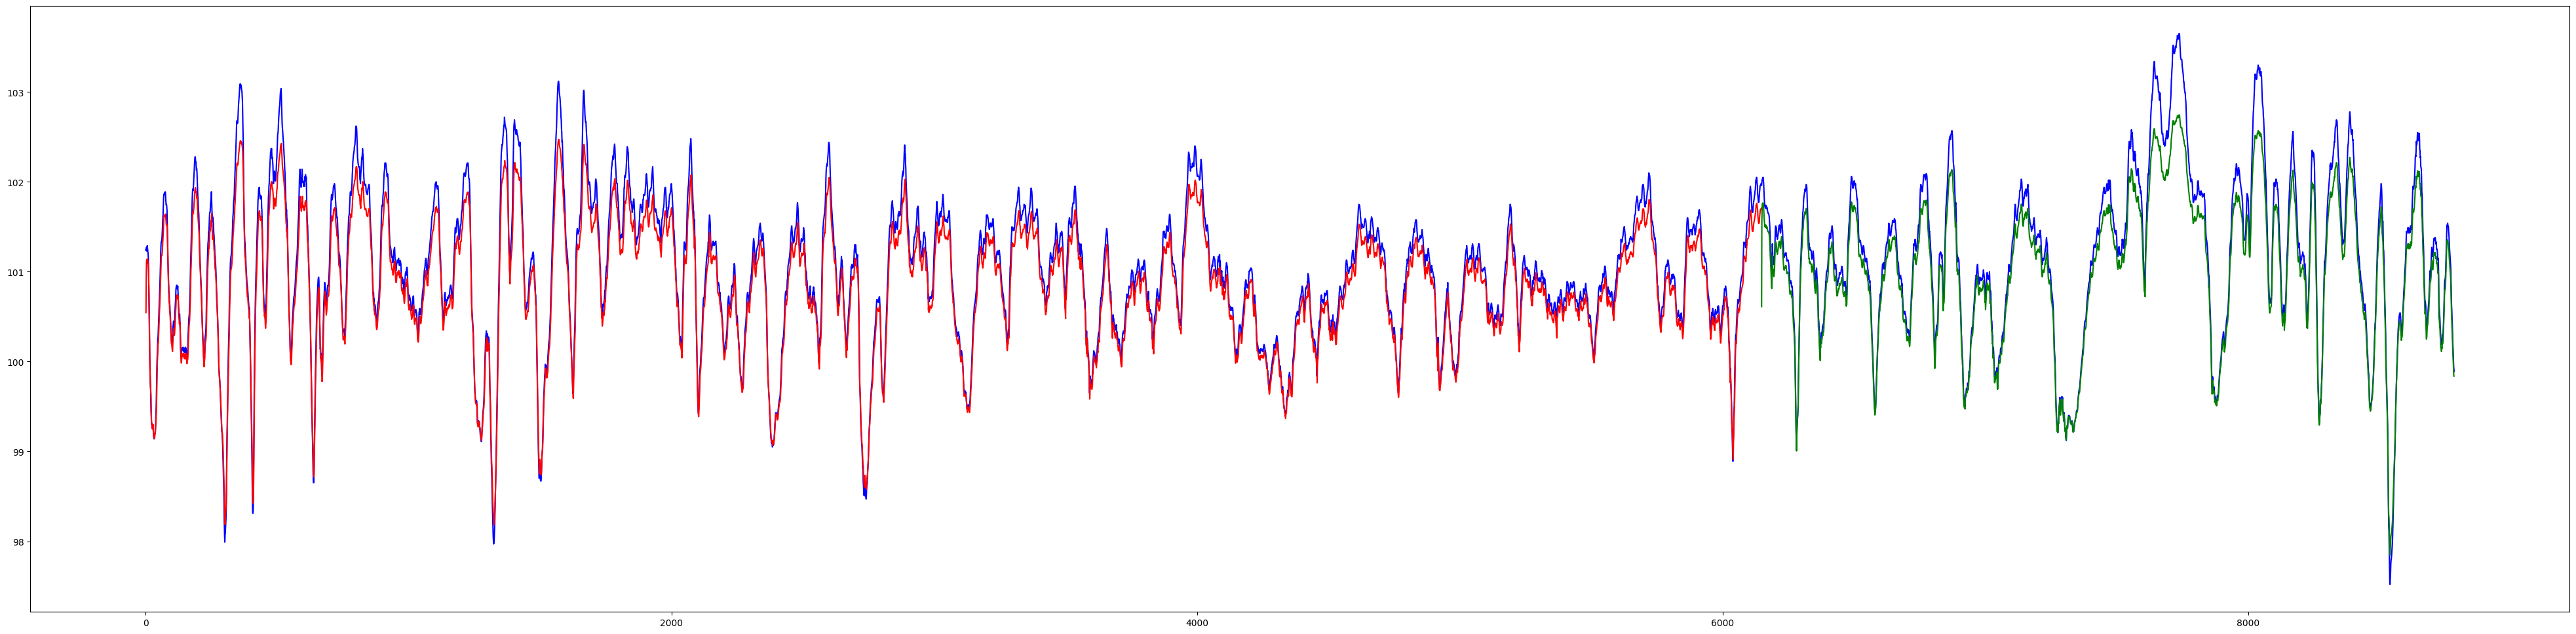

In [42]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]

    print("SMAPE:", smape_score(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MSE:", mean_squared_error(true, pred))
    print("R2:", r2_score(true, pred))

def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [50, 12]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

def validate_on_auto_measurement(model):
    valid_train, valid_test, valid_total = data_split(data)
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred

    print("GRU metrics: ")
    try:
        validate(y_pred_test, y_test)
    except:
        validate(y_pred_test.detach(), y_test.detach())
    plot_train_n_pred(X_train, X_test, valid_total, model)

validate_on_auto_measurement(model)

По метрикам:<br>

MAE около единицы, что является отличным показателем.<br>
RMSE, MSE в районе ~0.45, ~0.3, что является хорошим показателем (опять же, чем ниже и ближе к 0, тем лучше).<br>
SMAPE очень близок к нулю, что почти идеально.<br>
R2 ~= 0.9, что тоже является хорошим показателем (отчасти близко к единице.)<br>

#### TCN

TCN (Temporal Convolutional Network) - это тип нейронной сети, предназначенный для работы с последовательными данных, такими как временные ряды. Эта архитектура основана на использовании сверточных слоев для извлечения признаков из последовательных данных.

Подготовим данные.

In [46]:
# df_tcn = pd.DataFrame(data['Date'])
# df_tcn['Press_kPa'] = data['Press_kPa']
# df_tcn.set_index('Date', inplace=True)

lookback_window = 20

df_tcn = data.values

x, y = [], []
for i in range(lookback_window, len(df_tcn)):
    x.append(df_tcn[i - lookback_window:i])
    y.append(df_tcn[i])
x = np.array(x)
y = np.array(y)

Делим данные на обучающую и тестовые выборки

In [47]:
data

Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  Visibility_km  \
0       -1.8              -3.9         86                4            8.0   
1       -1.8              -3.7         87                4            8.0   
2       -1.8              -3.4         89                7            4.0   
3       -1.5              -3.2         88                6            4.0   
4       -1.5              -3.3         88                7            4.8   
...      ...               ...        ...              ...            ...   
8779     0.1              -2.7         81               30            9.7   
8780     0.2              -2.4         83               24            9.7   
8781    -0.5              -1.5         93               28            4.8   
8782    -0.2              -1.8         89               28            9.7   
8783     0.0              -2.1         86               30           11.3   

      Press_kPa  
0        101.24  
1        101.24  
2        101.26  
3        101.27  
4        101.23  
...         ...  
8779     100.13  
8780     100.03  
8781      99.95  
8782      99.91  
8783      99.89  

[8784 rows x 6 columns]

In [48]:
x_train = x[0:7000]
y_train = y[0:7000]
x_test = x[7000:]
y_test = y[7000:]

In [52]:
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.6 MB/s eta 0:00:00


In [56]:
from tcn import TCN, tcn_full_summary
from keras.layers import Input, Dense
from keras.models import Model

Определим модель и обучим её.

In [57]:
i = Input(shape=(lookback_window, 1))
m = TCN()(i)
m = Dense(1, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 tcn (TCN)                   (None, 64)                136256    
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 136321 (532.50 KB)
Trainable params: 136321 (532.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
model.fit(x_train, y_train, epochs=100, verbose=0)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filec37khgzc.py", line 48, in tf__call
        ag__.for_stmt(ag__.ld(self).residual_blocks, None, loop_body, get_state_1, set_state_1, ('x',), {'iterate_names': 'res_block'})
    File "/tmp/__autograph_generated_filec37khgzc.py", line 41, in loop_body
        (x, skip_out) = ag__.converted_call(ag__.ld(res_block), (ag__.ld(x),), dict(training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_file5oiezf9o.py", line 30, in tf__call
        ag__.for_stmt(ag__.ld(self).layers, None, loop_body, get_state, set_state, ('x1',), {'iterate_names': 'layer'})
    File "/tmp/__autograph_generated_file5oiezf9o.py", line 27, in loop_body
        x1 = ag__.if_exp(ag__.ld(training_flag), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope), 'training_flag')
    File "/tmp/__autograph_generated_file5oiezf9o.py", line 27, in <lambda>
        x1 = ag__.if_exp(ag__.ld(training_flag), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope), 'training_flag')

    ValueError: Exception encountered when calling layer 'tcn' (type TCN).
    
    in user code:
    
        File "/usr/local/lib/python3.10/dist-packages/tcn/tcn.py", line 344, in call  *
            x, skip_out = res_block(x, training=training)
        File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_file5oiezf9o.py", line 30, in tf__call
            ag__.for_stmt(ag__.ld(self).layers, None, loop_body, get_state, set_state, ('x1',), {'iterate_names': 'layer'})
        File "/tmp/__autograph_generated_file5oiezf9o.py", line 27, in loop_body
            x1 = ag__.if_exp(ag__.ld(training_flag), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope), 'training_flag')
        File "/tmp/__autograph_generated_file5oiezf9o.py", line 27, in <lambda>
            x1 = ag__.if_exp(ag__.ld(training_flag), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope), 'training_flag')
    
        ValueError: Exception encountered when calling layer 'residual_block_0' (type ResidualBlock).
        
        in user code:
        
            File "/usr/local/lib/python3.10/dist-packages/tcn/tcn.py", line 175, in call  *
                x1 = layer(x1, training=training) if training_flag else layer(x1)
            File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
                raise ValueError(
        
            ValueError: Input 0 of layer "conv1D_0" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 20, 6)
        
        
        Call arguments received by layer 'residual_block_0' (type ResidualBlock):
          • inputs=tf.Tensor(shape=(None, 20, 6), dtype=float32)
          • training=True
          • kwargs=<class 'inspect._empty'>
    
    
    Call arguments received by layer 'tcn' (type TCN):
      • inputs=tf.Tensor(shape=(None, 20, 6), dtype=float32)
      • training=True
      • kwargs=<class 'inspect._empty'>


Делаем предикты

In [61]:
y_pred = model.predict(x_test)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filec37khgzc.py", line 48, in tf__call
        ag__.for_stmt(ag__.ld(self).residual_blocks, None, loop_body, get_state_1, set_state_1, ('x',), {'iterate_names': 'res_block'})
    File "/tmp/__autograph_generated_filec37khgzc.py", line 41, in loop_body
        (x, skip_out) = ag__.converted_call(ag__.ld(res_block), (ag__.ld(x),), dict(training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_file5oiezf9o.py", line 30, in tf__call
        ag__.for_stmt(ag__.ld(self).layers, None, loop_body, get_state, set_state, ('x1',), {'iterate_names': 'layer'})
    File "/tmp/__autograph_generated_file5oiezf9o.py", line 27, in loop_body
        x1 = ag__.if_exp(ag__.ld(training_flag), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope), 'training_flag')
    File "/tmp/__autograph_generated_file5oiezf9o.py", line 27, in <lambda>
        x1 = ag__.if_exp(ag__.ld(training_flag), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope), 'training_flag')

    ValueError: Exception encountered when calling layer 'tcn' (type TCN).
    
    in user code:
    
        File "/usr/local/lib/python3.10/dist-packages/tcn/tcn.py", line 344, in call  *
            x, skip_out = res_block(x, training=training)
        File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_file5oiezf9o.py", line 30, in tf__call
            ag__.for_stmt(ag__.ld(self).layers, None, loop_body, get_state, set_state, ('x1',), {'iterate_names': 'layer'})
        File "/tmp/__autograph_generated_file5oiezf9o.py", line 27, in loop_body
            x1 = ag__.if_exp(ag__.ld(training_flag), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope), 'training_flag')
        File "/tmp/__autograph_generated_file5oiezf9o.py", line 27, in <lambda>
            x1 = ag__.if_exp(ag__.ld(training_flag), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope), lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope), 'training_flag')
    
        ValueError: Exception encountered when calling layer 'residual_block_0' (type ResidualBlock).
        
        in user code:
        
            File "/usr/local/lib/python3.10/dist-packages/tcn/tcn.py", line 175, in call  *
                x1 = layer(x1, training=training) if training_flag else layer(x1)
            File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
                raise ValueError(
        
            ValueError: Input 0 of layer "conv1D_0" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 20, 6)
        
        
        Call arguments received by layer 'residual_block_0' (type ResidualBlock):
          • inputs=tf.Tensor(shape=(None, 20, 6), dtype=float32)
          • training=False
          • kwargs=<class 'inspect._empty'>
    
    
    Call arguments received by layer 'tcn' (type TCN):
      • inputs=tf.Tensor(shape=(None, 20, 6), dtype=float32)
      • training=False
      • kwargs=<class 'inspect._empty'>


Отрисуем предсказания с истинными метками, покажем на графике и посчитаем метрики.

In [63]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

plt.plot([i for i in range(0, size)], y_train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test, label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], y_pred, label='TCN forecast')
plt.legend(fontsize="20")
plt.title('VPdef values, in mbar')
plt.ylabel('VPdef, (mbar)', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

print("TCN Metrics:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MSE:", mean_squared_error(y_test, y_pred))
print("SMAPE:", smape_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

NameError: name 'y_pred' is not defined

<Figure size 2000x900 with 0 Axes>